# HCLIM Validation

## Loading HCLIM data

Load .tab files and combine all TA (air temperature) data into one pandas dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyleoclim as pyleo
import os
import xarray as xr

In [2]:
# read all csvs and combine into one dataframe 

files = os.listdir('./datasets/')
data = []
for file in files:
    if ('_Ta' in file) and ('Tair' not in file):
        df = pd.read_csv(f'./datasets/{file}',sep='\t', skiprows=23)
        data.append(df)

df_ta = pd.concat(data)

In [4]:
# identifying all unique station IDs

stations_id = df_ta['ID'].unique()

In [5]:
# create dictionary for all stations with lat/lon, start/end date, and length of timeseries

ta_dict = {}
for id in stations_id:
    station_data = df_ta[df_ta['ID'] == id]
    station_name = station_data['Station'].unique()[0]
    mini = station_data['Date/Time'].min()
    maxi = station_data['Date/Time'].max()
    lat = station_data['Latitude'].unique()[0]
    lon = station_data['Longitude'].unique()[0]
    length = len(station_data['TTT monthly m [°C]'].values)
    ta_dict[id] = {'Station': station_name,
                'Date min': mini,
                'Date max': maxi,
                'Length': length,
                'Latitude': lat,
                'Longitude': lon}




In [6]:
# list 
old_ta = []
for id in stations_id:
    val = int(ta_dict[id]['Date min'][:-3])
    if 1850 >= val:
        old_ta.append(id)


In [7]:
old_ta_dict = {}
for id in old_ta:
    old_ta_dict[id] = ta_dict[id]

In [8]:
sorted_date_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Date min']))

In [9]:
sorted_len_dict = dict(sorted(old_ta_dict.items(), 
                         key=lambda x: x[1]['Length'],
                         reverse = True))

## Loading Paris Dataset (HCLIM)
While there was a selection of close to 3000 stations in which temperaure data was recorded, Paris, specificially the EKF400 dataset has one of the longest date ranges and largest set of data points. 

In [72]:
df_paris = df_ta[df_ta['ID'] == 'EKF400v2t_002']

In [73]:
# converting date from string to decimal format 

from datetime import datetime

def date_to_decimal_year(date_str):
    # Parse the date string
    date = datetime.strptime(date_str, '%Y-%m')
    
    # Get the year and month
    year = date.year
    month = date.month
    
    # Convert to decimal year (year + fraction of the year)
    decimal_year = year + (month - 1) / 12
    
    return decimal_year


In [74]:
df_paris['Date/Time'] = df_paris['Date/Time'].apply(date_to_decimal_year)

### Adjusting anomalies to remove seasonal cycles and annualize

In [75]:
'''# Extract months from the decimal years
months = ((df_paris['Date/Time'] % 1) * 12 + 1).round()

# Add months to the dataframe
df_paris['month'] = months

# Calculate monthly climatology
climatology = df_paris.groupby('month')['TTT monthly m [°C]'].mean()

# Remove seasonal cycle
df_paris['seasonality'] = df_paris.apply(
    lambda x: x['TTT monthly m [°C]'] - climatology[x['month']], 
    axis=1)'''


"# Extract months from the decimal years\nmonths = ((df_paris['Date/Time'] % 1) * 12 + 1).round()\n\n# Add months to the dataframe\ndf_paris['month'] = months\n\n# Calculate monthly climatology\nclimatology = df_paris.groupby('month')['TTT monthly m [°C]'].mean()\n\n# Remove seasonal cycle\ndf_paris['seasonality'] = df_paris.apply(\n    lambda x: x['TTT monthly m [°C]'] - climatology[x['month']], \n    axis=1)"

KeyError: 'seasonality'

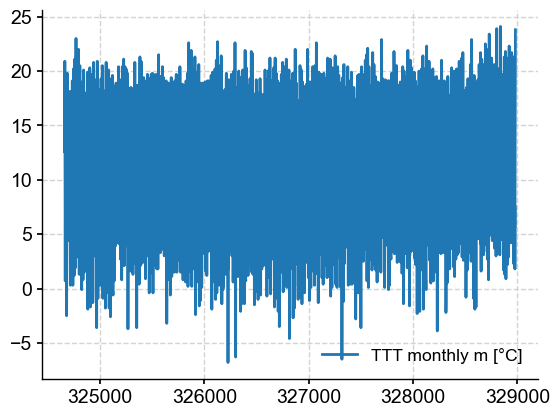

In [76]:
df_paris['TTT monthly m [°C]'].plot(legend='not')
df_paris['seasonality'].plot(legend='seasoned')
plt.show()

In [77]:
# annualizing (yearly average instead of monthly datapoints)
# taking anomalies with reference period 1951-1980 (same as LMR)

years = np.floor(df_paris['Date/Time'])

paris_annual = df_paris.groupby(years)['TTT monthly m [°C]'].mean()

ref_period_mean = paris_annual[
    (paris_annual.index >= 1951) & 
    (paris_annual.index <= 1980)
].mean()


# Calculate anomalies
paris_annual_anomalies = paris_annual - ref_period_mean

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature anomaly [°C]'>)

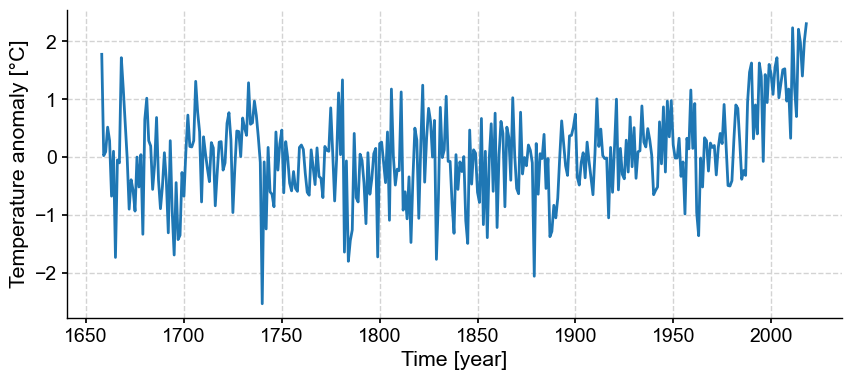

In [78]:
# making the seasonality removed and annualized data into a pyleo series
# this apparently does not make a difference! when you annualize the data, seasonal cycles are automatically removed

timey = paris_annual_anomalies.index.values  
valuey = paris_annual_anomalies.values

paris_annual_ps = pyleo.Series(
    time=timey,
    value=valuey,
    time_name='Year',
    time_unit= 'year',
    value_name='Temperature anomaly',
    value_unit='°C'
)

paris_annual_ps.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature anomaly [°C]'>)

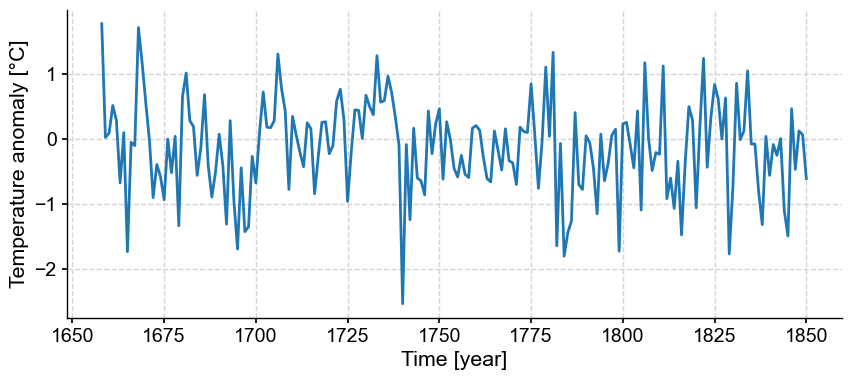

In [79]:
# slice series into time interval we want
# in this case, 1650-1850

paris_annual_slice = paris_annual_ps.sel(time=slice(1650, 1850)) # not pyloclim (annual mean)
paris_annual_slice.plot()

## Loading New Haven, CT (HCLIM)

In [80]:
df_nh = df_ta[df_ta['ID'] == 'BE-68050'] 

In [81]:
df_nh['Date/Time'] = df_nh['Date/Time'].apply(date_to_decimal_year)

<Axes: xlabel='Date/Time'>

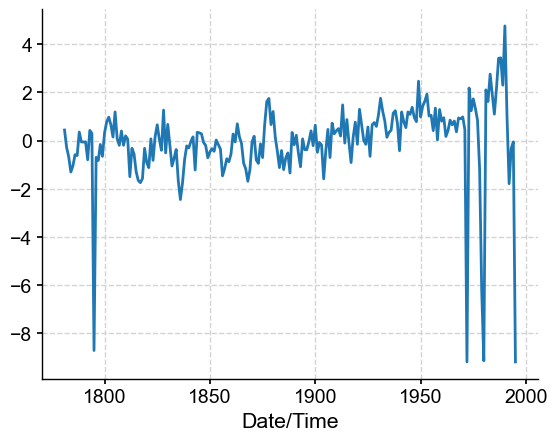

In [82]:
years = np.floor(df_nh['Date/Time'])

nh_annual = df_nh.groupby(years)['TTT monthly m [°C]'].mean()

ref_period_mean = nh_annual[
    (nh_annual.index >= 1951) & 
    (nh_annual.index <= 1980)
].mean()


# Calculate anomalies
nh_annual_anomalies = nh_annual - ref_period_mean

nh_annual_anomalies.plot()

NaNs have been detected and dropped.
Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature anomaly [°C]'>)

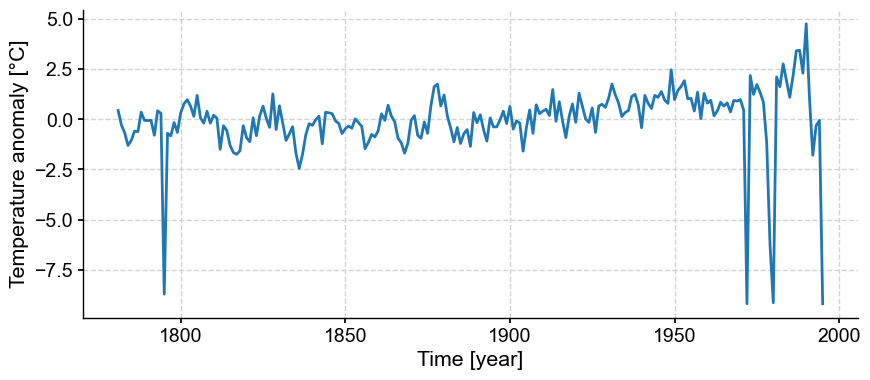

In [83]:
timey = nh_annual_anomalies.index.values  
valuey = nh_annual_anomalies.values

nh_annual_ps = pyleo.Series(
    time=timey,
    value=valuey,
    time_name='Year',
    time_unit= 'year',
    value_name='Temperature anomaly',
    value_unit='°C'
)

nh_annual_ps.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [year]', ylabel='Temperature anomaly [°C]'>)

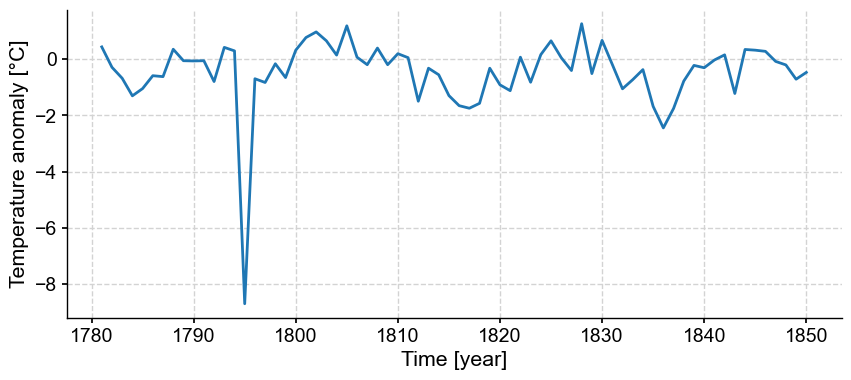

In [84]:
nh_slice = nh_annual_ps.sel(time=slice(1750, 1850))

nh_slice.plot()

## Loading LMRv2.1 

loading LMRv2.1 offline from the cloud using xarray. 

In [85]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

<xarray.Dataset>
Dimensions:        (time: 2001, MCrun: 20, lat: 91, lon: 180)
Coordinates:
  * lat            (lat) float32 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time           (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun
Data variables: (12/14)
    air_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    air_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_mean    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    hgt500_spread  (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_mean      (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    pdsi_spread    (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    ...             ...
    prate_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prate_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_mean     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    prmsl_spread   (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_mean       (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
    sst_spread     (time, MCrun, lat, lon) float32 dask.array<chunksize=(1, 20, 91, 180), meta=np.ndarray>
Attributes:
    comment:      File contains ensemble spread values for each Monte-Carlo r...
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_z500

### Loading Paris gridpoint (LMR)

taking the closest gridpoint to our Paris HCLIM station to do a gridpoint validation 

In [86]:
lats = round(df_paris['Latitude'].iloc[0])
longs = round(df_paris['Longitude'].iloc[0])

grid_point_paris = lmr_ds_gridded.air_mean.isel(lat=lats, lon=longs)

In [87]:
# turning LMR data at Paris gridpoint into pyleo ensemble series. One for each MC iteration

time_values_numeric = np.array([t.year for t in grid_point_paris.time.values])
mask = (time_values_numeric >= 1650) & (time_values_numeric <= 1850)

traces = []
for i in range(grid_point_paris.shape[1]):
    values = grid_point_paris[mask, i].values
    
    series = pyleo.Series(
        time=time_values_numeric[mask],  # Only use times within our period
        value=values,
        time_name='Year',
        time_unit='CE',
        value_name='Air Temperature',
        value_unit='°C',
        label=f'Ensemble Member {i+1}',
        verbose=False
    )
    traces.append(series)

# Create an EnsembleSeries object
ensemble = pyleo.EnsembleSeries(traces)

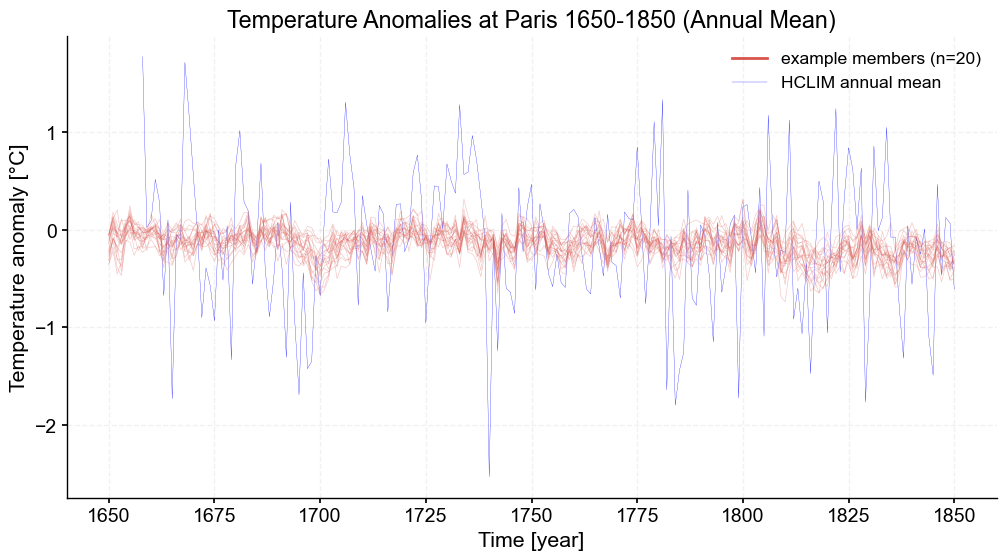

In [88]:
# Create visualization
fig, ax = ensemble.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6),
    lgd_kwargs = {'labels': ['MC iterations']}
)

paris_annual_slice.plot(ax=ax, linewidth=0.2, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at Paris 1650-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

### Loading New Haven Gridpoint (LMR)

In [89]:

lats = round(df_nh['Latitude'].iloc[0])
longs = round(df_nh['Longitude'].iloc[0])

grid_point_nh = lmr_ds_gridded.air_mean.isel(lat=lats, lon=longs)

In [90]:
# Create mask based on time values
time_values_numeric = np.array([t.year for t in grid_point_nh.time.values])
mask = (time_values_numeric >= 1780) & (time_values_numeric <= 1850)

traces = []
for i in range(grid_point_nh.shape[1]):
    # Apply mask directly here, like in the Paris code
    values = grid_point_nh[mask, i].values
    
    series = pyleo.Series(
        time=time_values_numeric[mask],  # Only use times within our period
        value=values,
        time_name='Year',
        time_unit='CE',
        value_name='Air Temperature',
        value_unit='°C',
        label=f'Ensemble Member {i+1}',
        verbose=False
    )
    traces.append(series)

# Create an EnsembleSeries object
ensemble_nh = pyleo.EnsembleSeries(traces)



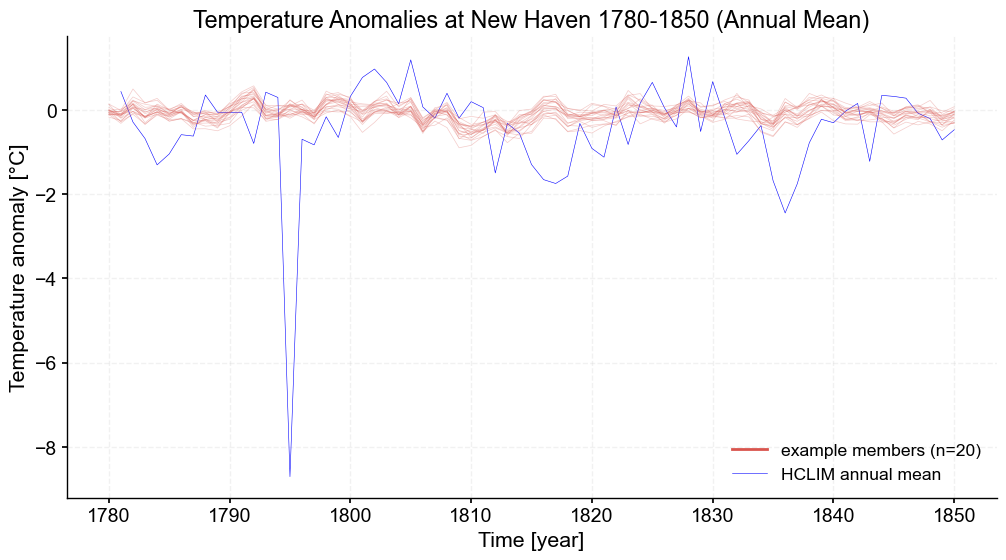

In [91]:
# Create visualization
fig, ax = ensemble_nh.plot_traces(
    num_traces=20,
    seed=42,
    figsize=(12, 6)
)

nh_slice.plot(ax=ax, linewidth=0.4, color='blue', label='HCLIM annual mean')

ax.set_title('Temperature Anomalies at New Haven 1780-1850 (Annual Mean)')
ax.grid(True, alpha=0.3)
ax.legend()

## Correlation

In [95]:
# Try direct calculation first
spread_nh = lmr_ds_gridded.air_spread.isel(lat=lats, lon=longs)

In [96]:
spread_nh

<xarray.DataArray 'air_spread' (time: 2001, MCrun: 20)>
dask.array<getitem, shape=(2001, 20), dtype=float32, chunksize=(1, 20), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 -8.0
    lon      float32 214.0
  * time     (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun
Attributes:
    GRIB_id:        11
    GRIB_name:      TMP
    actual_range:   [0.08871963620185852, 3.1603903770446777]
    dataset:        NOAA Last Millennium Reanalysis version 1.1 Annual Averages
    level_desc:     2m
    long_name:      Air Temperature at Surface
    standard_name:  air_temperature
    statistic:      Ensemble Spread
    units:          degK
    valid_range:    [-20.0, 20.0]
    var_desc:       Air temperature